# Emotion Detection Model
This notebook trains an emotion detection model using convolutional neural networks with proper data handling, class balancing, and evaluation.

In [1]:

!pip install kaggle
!pip install tensorflow
!pip install scikit-learn


In [2]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:

# Upload kaggle.json before running this
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [4]:

!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip -q emotion-detection-fer.zip -d data


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
  0% 0.00/65.2M [00:00<?, ?B/s]
100% 65.2M/65.2M [00:00<00:00, 1.37GB/s]


In [5]:
train_dir = "data/train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [6]:

x_batch, y_batch = next(train_generator)
print("X batch shape:", x_batch.shape, "min:", x_batch.min(), "max:", x_batch.max())
print("Y batch shape:", y_batch.shape)
print("Sample labels:", y_batch[0])


X batch shape: (32, 48, 48, 1) min: 0.0 max: 1.0
Y batch shape: (32, 7)
Sample labels: [0. 0. 0. 1. 0. 0. 0.]


In [7]:

print("Class distribution:", Counter(train_generator.classes))
print("Class indices:", train_generator.class_indices)


Class distribution: Counter({np.int32(3): 5772, np.int32(4): 3972, np.int32(5): 3864, np.int32(2): 3278, np.int32(0): 3196, np.int32(6): 2537, np.int32(1): 349})
Class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,917,191 (22.57 MB)

 Trainable params: 5,914,183 (22.56 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [10]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [13]:
EPOCHS = 30
FINE_TUNING_EPOCHS = 20

In [14]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1578 - loss: 2.5199
Epoch 1: val_accuracy improved from -inf to 0.14823, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.1578 - loss: 2.5194 - val_accuracy: 0.1482 - val_loss: 2.1040
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1749 - loss: 2.1226
Epoch 2: val_accuracy improved from 0.14823 to 0.20380, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.1749 - loss: 2.1226 - val_accuracy: 0.2038 - val_loss: 1.9344
Epoch 3/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1829 - loss: 2.0677
Epoch 3: val_accuracy did not improve from 0.20380
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.1829 - loss: 2.0677 - val_accuracy: 0.1554 - val_loss: 1.9629
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1813 - loss: 2.0516
Epoch 4: val_accuracy improved from 0.20380 to 0.20711, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.1813 - loss: 2.0516 - val_accuracy: 0.2071 - val_loss: 1.9096
Epoch 5/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1942 - loss: 2.0043
Epoch 5: val_accuracy did not improve from 0.20711
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.1942 - loss: 2.0043 - val_accuracy: 0.2061 - val_loss: 1.9062
Epoch 6/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2089 - loss: 1.9644
Epoch 6: val_accuracy improved from 0.20711 to 0.26476, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.2089 - loss: 1.9644 - val_accuracy: 0.2648 - val_loss: 1.8313
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2152 - loss: 1.9446
Epoch 7: val_accuracy did not improve from 0.26476
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2152 - loss: 1.9446 - val_accuracy: 0.2564 - val_loss: 1.8314
Epoch 8/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2394 - loss: 1.9155
Epoch 8: val_accuracy improved from 0.26476 to 0.30030, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2394 - loss: 1.9155 - val_accuracy: 0.3003 - val_loss: 1.7885
Epoch 9/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2664 - loss: 1.8371
Epoch 9: val_accuracy improved from 0.30030 to 0.30082, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2664 - loss: 1.8371 - val_accuracy: 0.3008 - val_loss: 1.7635
Epoch 10/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2772 - loss: 1.8283
Epoch 10: val_accuracy improved from 0.30082 to 0.33670, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2772 - loss: 1.8283 - val_accuracy: 0.3367 - val_loss: 1.6840
Epoch 11/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3103 - loss: 1.7511
Epoch 11: val_accuracy improved from 0.33670 to 0.36805, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.3103 - loss: 1.7511 - val_accuracy: 0.3681 - val_loss: 1.6401
Epoch 12/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3259 - loss: 1.7227
Epoch 12: val_accuracy did not improve from 0.36805
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.3259 - loss: 1.7226 - val_accuracy: 0.3409 - val_loss: 1.6948
Epoch 13/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3486 - loss: 1.6591
Epoch 13: val_accuracy did not improve from 0.36805
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.3486 - loss: 1.6591 - val_accuracy: 0.3642 - val_loss: 1.6566
Epoch 14/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3663 - loss: 1.6483
Epoch 14: val_accuracy improved from 0.36805 to 0.39906, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.3663 - loss: 1.6482 - val_accuracy: 0.3991 - val_loss: 1.5648
Epoch 15/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3758 - loss: 1.6296
Epoch 15: val_accuracy did not improve from 0.39906
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.3758 - loss: 1.6296 - val_accuracy: 0.3931 - val_loss: 1.6250
Epoch 16/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3885 - loss: 1.5951
Epoch 16: val_accuracy improved from 0.39906 to 0.43546, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.3885 - loss: 1.5951 - val_accuracy: 0.4355 - val_loss: 1.4873
Epoch 17/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4058 - loss: 1.5445
Epoch 17: val_accuracy improved from 0.43546 to 0.44261, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.4058 - loss: 1.5444 - val_accuracy: 0.4426 - val_loss: 1.4901
Epoch 18/30
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4149 - loss: 1.5275
Epoch 18: val_accuracy did not improve from 0.44261
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4149 - loss: 1.5274 - val_accuracy: 0.4419 - val_loss: 1.4778
Epoch 19/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4305 - loss: 1.4460
Epoch 19: val_accuracy improved from 0.44261 to 0.44748, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.4305 - loss: 1.4460 - val_accuracy: 0.4475 - val_loss: 1.4633
Epoch 20/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4368 - loss: 1.4595
Epoch 20: val_accuracy did not improve from 0.44748
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4368 - loss: 1.4595 - val_accuracy: 0.4435 - val_loss: 1.4859
Epoch 21/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4510 - loss: 1.4332
Epoch 21: val_accuracy improved from 0.44748 to 0.48023, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4510 - loss: 1.4332 - val_accuracy: 0.4802 - val_loss: 1.3726
Epoch 22/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4630 - loss: 1.3874
Epoch 22: val_accuracy did not improve from 0.48023
718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.4630 - loss: 1.3874 - val_accuracy: 0.4548 - val_loss: 1.4436
Epoch 23/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4721 - loss: 1.3724
Epoch 23: val_accuracy improved from 0.48023 to 0.48528, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.4721 - loss: 1.3724 - val_accuracy: 0.4853 - val_loss: 1.3700
Epoch 24/30
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4794 - loss: 1.3478
Epoch 24: val_accuracy improved from 0.48528 to 0.48737, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4794 - loss: 1.3479 - val_accuracy: 0.4874 - val_loss: 1.3486
Epoch 25/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4678 - loss: 1.3651
Epoch 25: val_accuracy improved from 0.48737 to 0.51559, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4679 - loss: 1.3651 - val_accuracy: 0.5156 - val_loss: 1.2845
Epoch 26/30
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4847 - loss: 1.3292
Epoch 26: val_accuracy did not improve from 0.51559
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.4847 - loss: 1.3292 - val_accuracy: 0.5029 - val_loss: 1.3021
Epoch 27/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4863 - loss: 1.2904
Epoch 27: val_accuracy improved from 0.51559 to 0.51960, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4863 - loss: 1.2904 - val_accuracy: 0.5196 - val_loss: 1.2673
Epoch 28/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4987 - loss: 1.2921
Epoch 28: val_accuracy improved from 0.51960 to 0.53388, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.4987 - loss: 1.2921 - val_accuracy: 0.5339 - val_loss: 1.2491
Epoch 29/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5062 - loss: 1.2889
Epoch 29: val_accuracy did not improve from 0.53388
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5062 - loss: 1.2889 - val_accuracy: 0.4673 - val_loss: 1.4582
Epoch 30/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4997 - loss: 1.3090
Epoch 30: val_accuracy did not improve from 0.53388
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.4997 - loss: 1.3089 - val_accuracy: 0.4562 - val_loss: 1.4640


In [15]:
history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5233 - loss: 1.2694 - val_accuracy: 0.5497 - val_loss: 1.1991
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5389 - loss: 1.2211 - val_accuracy: 0.5614 - val_loss: 1.1786
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.5509 - loss: 1.1879 - val_accuracy: 0.5513 - val_loss: 1.1882
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.5540 - loss: 1.1741 - val_accuracy: 0.5553 - val_loss: 1.1909
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.5542 - loss: 1.1639 - val_accuracy: 0.5762 - val_loss: 1.1530
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.5575 - loss: 1.1647 - val_accuracy: 0.5724 - val_loss: 1.1276
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.5676 - loss: 1.1425 - val_accuracy: 0.5922 - val_loss: 1.1193
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5723 - loss: 1.1221 - 

In [16]:
model.save("emotion_model.keras")

In [17]:
history_df = pd.concat([
    pd.DataFrame(history.history),
    pd.DataFrame(history_.history)
], ignore_index=True)


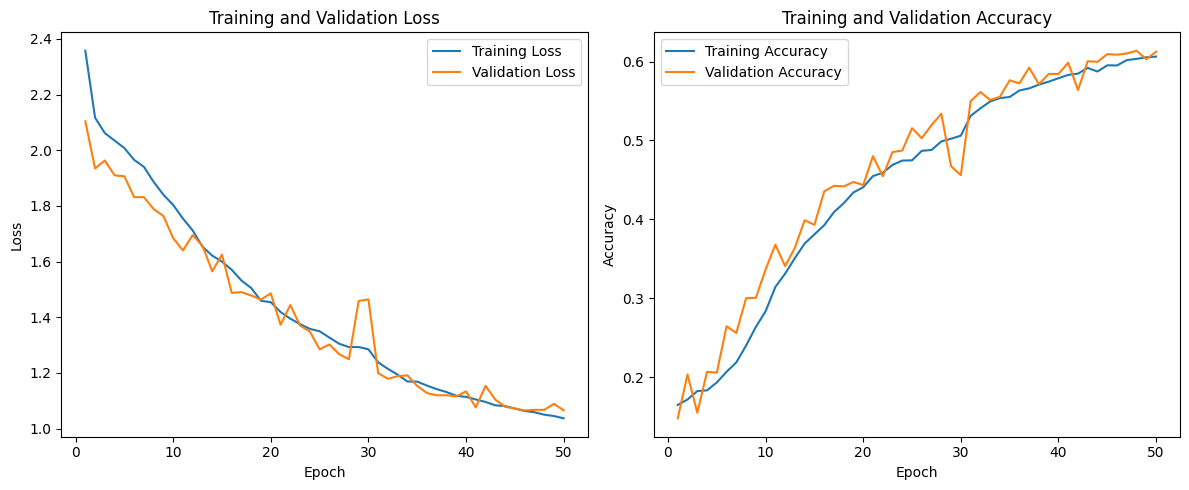

In [18]:
history_df['epoch'] = history_df.index + 1

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['loss'], label='Training Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['epoch'], history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


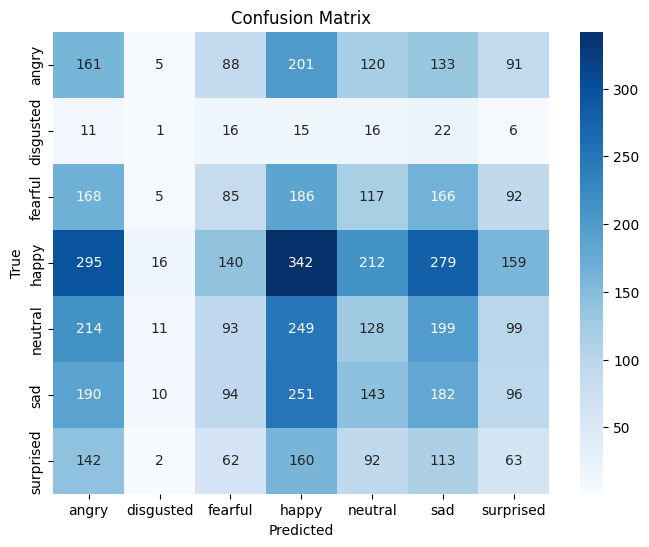

In [19]:
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
